In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import lite
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import random, os
from sklearn.metrics import confusion_matrix
from matplotlib.image import imread
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.applications import EfficientNetB0
from keras.preprocessing.image import ImageDataGenerator


In [3]:
data = pd.read_csv("/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/train.csv")

data

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0
...,...,...
3657,ffa47f6a7bf4,2
3658,ffc04fed30e6,0
3659,ffcf7b45f213,2
3660,ffd97f8cd5aa,0


In the diagnosis, there are numerical values 0,1,2,3,4 which are 
0 - No Diabetics
1 - mild
2 - moderate
3 - severe
4 - proliferate DR

In other words, other than 0 all other are diabetics

In [4]:
data['diagnosis_type'] = data['diagnosis'].map({0:'No_DR',1:'Mild',2:'Moderate',3:'Severe',4:'Proliferate_DR'})
data['outcome'] = data['diagnosis'].map({0:'No_DR', 1: 'DR',2:'DR',3:'DR',4:'DR'})

data

,id_code,diagnosis,diagnosis_type,outcome
0,000c1434d8d7,2,Moderate,DR
1,001639a390f0,4,Proliferate_DR,DR
2,0024cdab0c1e,1,Mild,DR
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR
...,...,...,...,...
3657,ffa47f6a7bf4,2,Moderate,DR
3658,ffc04fed30e6,0,No_DR,No_DR
3659,ffcf7b45f213,2,Moderate,DR
3660,ffd97f8cd5aa,0,No_DR,No_DR


<AxesSubplot:>

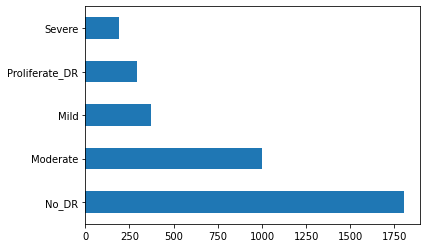

In [5]:
data['diagnosis_type'].value_counts().plot(kind='barh')

#data['outcome'].value_counts().plot(kind='barh')

stratify ensures that each split has a similar distribution of classes

In [6]:
data['image_id'] = data['id_code'].apply(lambda x: x+'.png')

train_df, temp_df = train_test_split(data, test_size=0.2, stratify=data['diagnosis'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['diagnosis'], random_state=42)


print(f"train: {len(train_df)} | val: {len(val_df)} | test: {len(test_df)}")


train: 2929 | val: 366 | test: 367


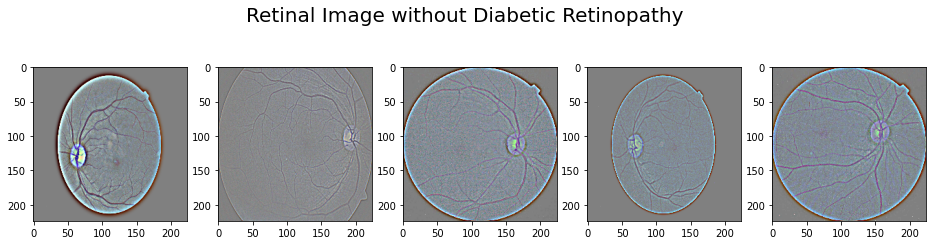

In [11]:
#Viewing the dataset
import cv2

path = '/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

No_DR_Img = os.listdir(path + '/No_DR/')
Mild_Img = os.listdir(path + '/Mild/')
Moderate_Img = os.listdir(path + '/Moderate/')
Proliferate_DR_Img = os.listdir(path + '/Proliferate_DR/')
Severe_Img = os.listdir(path + '/Severe/')

fig = plt.figure(figsize=(16,4))

for i in range(5):
    plt.subplot(1, 5, i+1)
    img = cv2.imread(path+'/No_DR/'+ No_DR_Img[i])
    plt.imshow(img)
plt.suptitle("Retinal Image without Diabetic Retinopathy",fontsize=20)
plt.show()

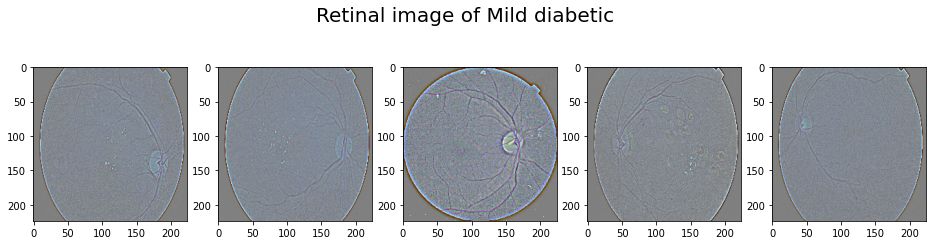

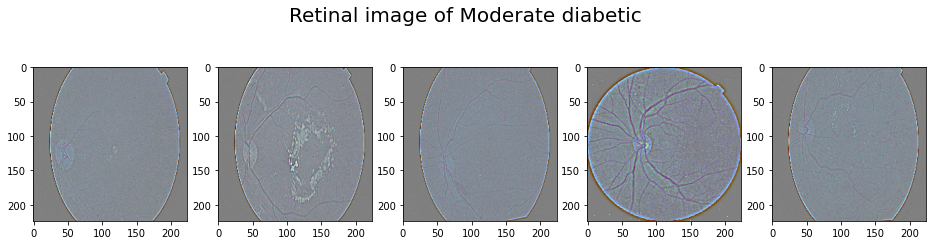

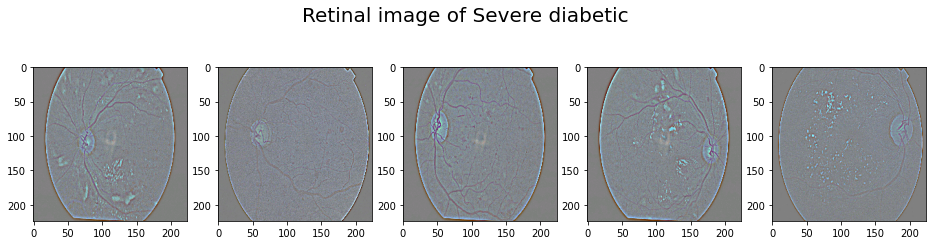

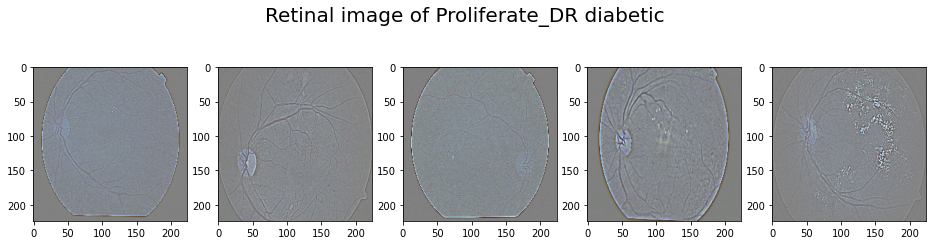

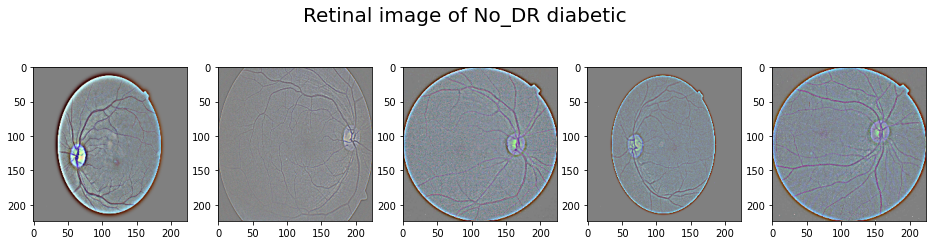

In [15]:
def display_images(directory_name, directory_path):
    fig = plt.figure(figsize=(16,4))
    for i in range(5):
        plt.subplot(1,5,i+1)
        img = cv2.imread(path+f'/{directory_name}/'+directory_path[i])
        plt.imshow(img)
    plt.suptitle(f'Retinal image of {directory_name} diabetic', fontsize=20)
    plt.show()

display_images('Mild', Mild_Img)
display_images('Moderate', Moderate_Img)
display_images('Severe', Severe_Img)
display_images('Proliferate_DR', Proliferate_DR_Img)
display_images('No_DR', No_DR_Img)

In [48]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32
CLASSES = 5


base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)

# Copy images to respective working directory
src_dir = r'../input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images'

def copy_images(dir_path, name):
    for index, row in dir_path.iterrows():
        diagnosis = row['diagnosis_type']
        binary_diagnosis = row['outcome']
        id_code = row['id_code'] + ".png"
        srcfile = os.path.join(src_dir, diagnosis, id_code)
        dstfile = os.path.join(name, binary_diagnosis)
        os.makedirs(dstfile, exist_ok = True)
        shutil.copy(srcfile, dstfile)

copy_images(train_df, 'train')
copy_images(val_df, 'val')
copy_images(val_df, 'test')


train_dir = 'train'
val_dir = 'val'
test_dir = 'test'

train_datagen = ImageDataGenerator(
    rescale = 1./255,  #normalize the image pixels to 0-1
    
).flow_from_directory(  #loads the images from directory organized by class folders
    train_dir, #path to training images
    target_size = IMAGE_SIZE, #resize of images
    batch_size = BATCH_SIZE,
    #class_mode = 'sparse' #labels the images 0-4 which is integer labels using sparse_categorical_crossentropy
)

val_datagen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    val_dir,
    target_size = IMAGE_SIZE,
    shuffle=True
    #class_mode = 'sparse'
)

test_datagen = ImageDataGenerator(rescale = 1./255).flow_from_directory(
    test_dir,
    target_size = IMAGE_SIZE,
    batch_size = BATCH_SIZE,
    #class_mode = 'sparse',
    shuffle = False
)



Found 2929 images belonging to 2 classes.
Found 366 images belonging to 2 classes.
Found 366 images belonging to 2 classes.


In [52]:
model = tf.keras.Sequential([
    layers.Conv2D(32,(3,3), activation='relu', input_shape=(224,224,3)),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation='softmax') #2 -> number of classes DR & NO_DR
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr = 1e-5), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['acc'])
history = model.fit(
    train_datagen,
    epochs=40,
    validation_data = val_datagen
)

Epoch 1/40
92/92 [==============================] - 108s 1s/step - loss: 0.2425 - acc: 0.9044 - val_loss: 0.6646 - val_acc: 0.5492
Epoch 2/40
92/92 [==============================] - 109s 1s/step - loss: 0.1453 - acc: 0.9536 - val_loss: 0.7746 - val_acc: 0.5082
Epoch 3/40
92/92 [==============================] - 107s 1s/step - loss: 0.1221 - acc: 0.9570 - val_loss: 0.5215 - val_acc: 0.7842
Epoch 4/40
92/92 [==============================] - 107s 1s/step - loss: 0.0908 - acc: 0.9734 - val_loss: 0.4347 - val_acc: 0.7869
Epoch 5/40
92/92 [==============================] - 107s 1s/step - loss: 0.0778 - acc: 0.9737 - val_loss: 0.2957 - val_acc: 0.8880
Epoch 6/40
92/92 [==============================] - 107s 1s/step - loss: 0.0537 - acc: 0.9846 - val_loss: 0.3302 - val_acc: 0.8525
Epoch 7/40
92/92 [==============================] - 107s 1s/step - loss: 0.0475 - acc: 0.9884 - val_loss: 0.2231 - val_acc: 0.9044
Epoch 8/40
92/92 [==============================] - 107s 1s/step - loss: 0.0355 - a

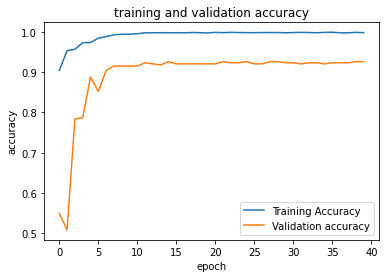

In [54]:
plt.plot(history.history['acc'], label='Training Accuracy')
plt.plot(history.history['val_acc'], label='Validation accuracy')
plt.title('training and validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [55]:
loss, accuracy = model.evaluate_generator(test_datagen, verbose=2)
print(f"loss = {loss} accuracy = {accuracy}")

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


12/12 - 4s - loss: 0.3331 - acc: 0.9262
loss = 0.333111047744751 accuracy = 0.9262295365333557


In [62]:
#showing the output of image

import cv2

def predict_class_image(path):
    im = cv2.imread(path)
    RGBImage = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    RGBImage = cv2.resize(RGBImage, (224,224))
    plt.imshow(RGBImage)
    image = np.array(RGBImage) / 255.0
    
    predict=model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')



DR


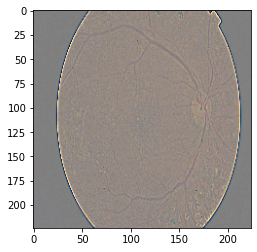

In [63]:
predict_class_image("/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/Proliferate_DR/001639a390f0.png")

No DR


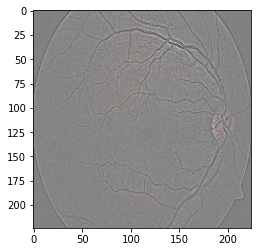

In [64]:
predict_class_image("/kaggle/input/diabetic-retinopathy-224x224-gaussian-filtered/gaussian_filtered_images/gaussian_filtered_images/No_DR/0097f532ac9f.png")